### Possible goals
* find order patterns by region

In [55]:
import pandas as pd
from sklearn import cluster
wholesale = pd.DataFrame(pd.read_csv('Wholesale_customers_data.csv'))

# wholesale.isnull().sum()
# wholesale.duplicated().value_counts()

wholesale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


array([[<Axes: title={'center': 'Channel'}>,
        <Axes: title={'center': 'Region'}>,
        <Axes: title={'center': 'Fresh'}>],
       [<Axes: title={'center': 'Milk'}>,
        <Axes: title={'center': 'Grocery'}>,
        <Axes: title={'center': 'Frozen'}>],
       [<Axes: title={'center': 'Detergents_Paper'}>,
        <Axes: title={'center': 'Delicatessen'}>, <Axes: >]], dtype=object)

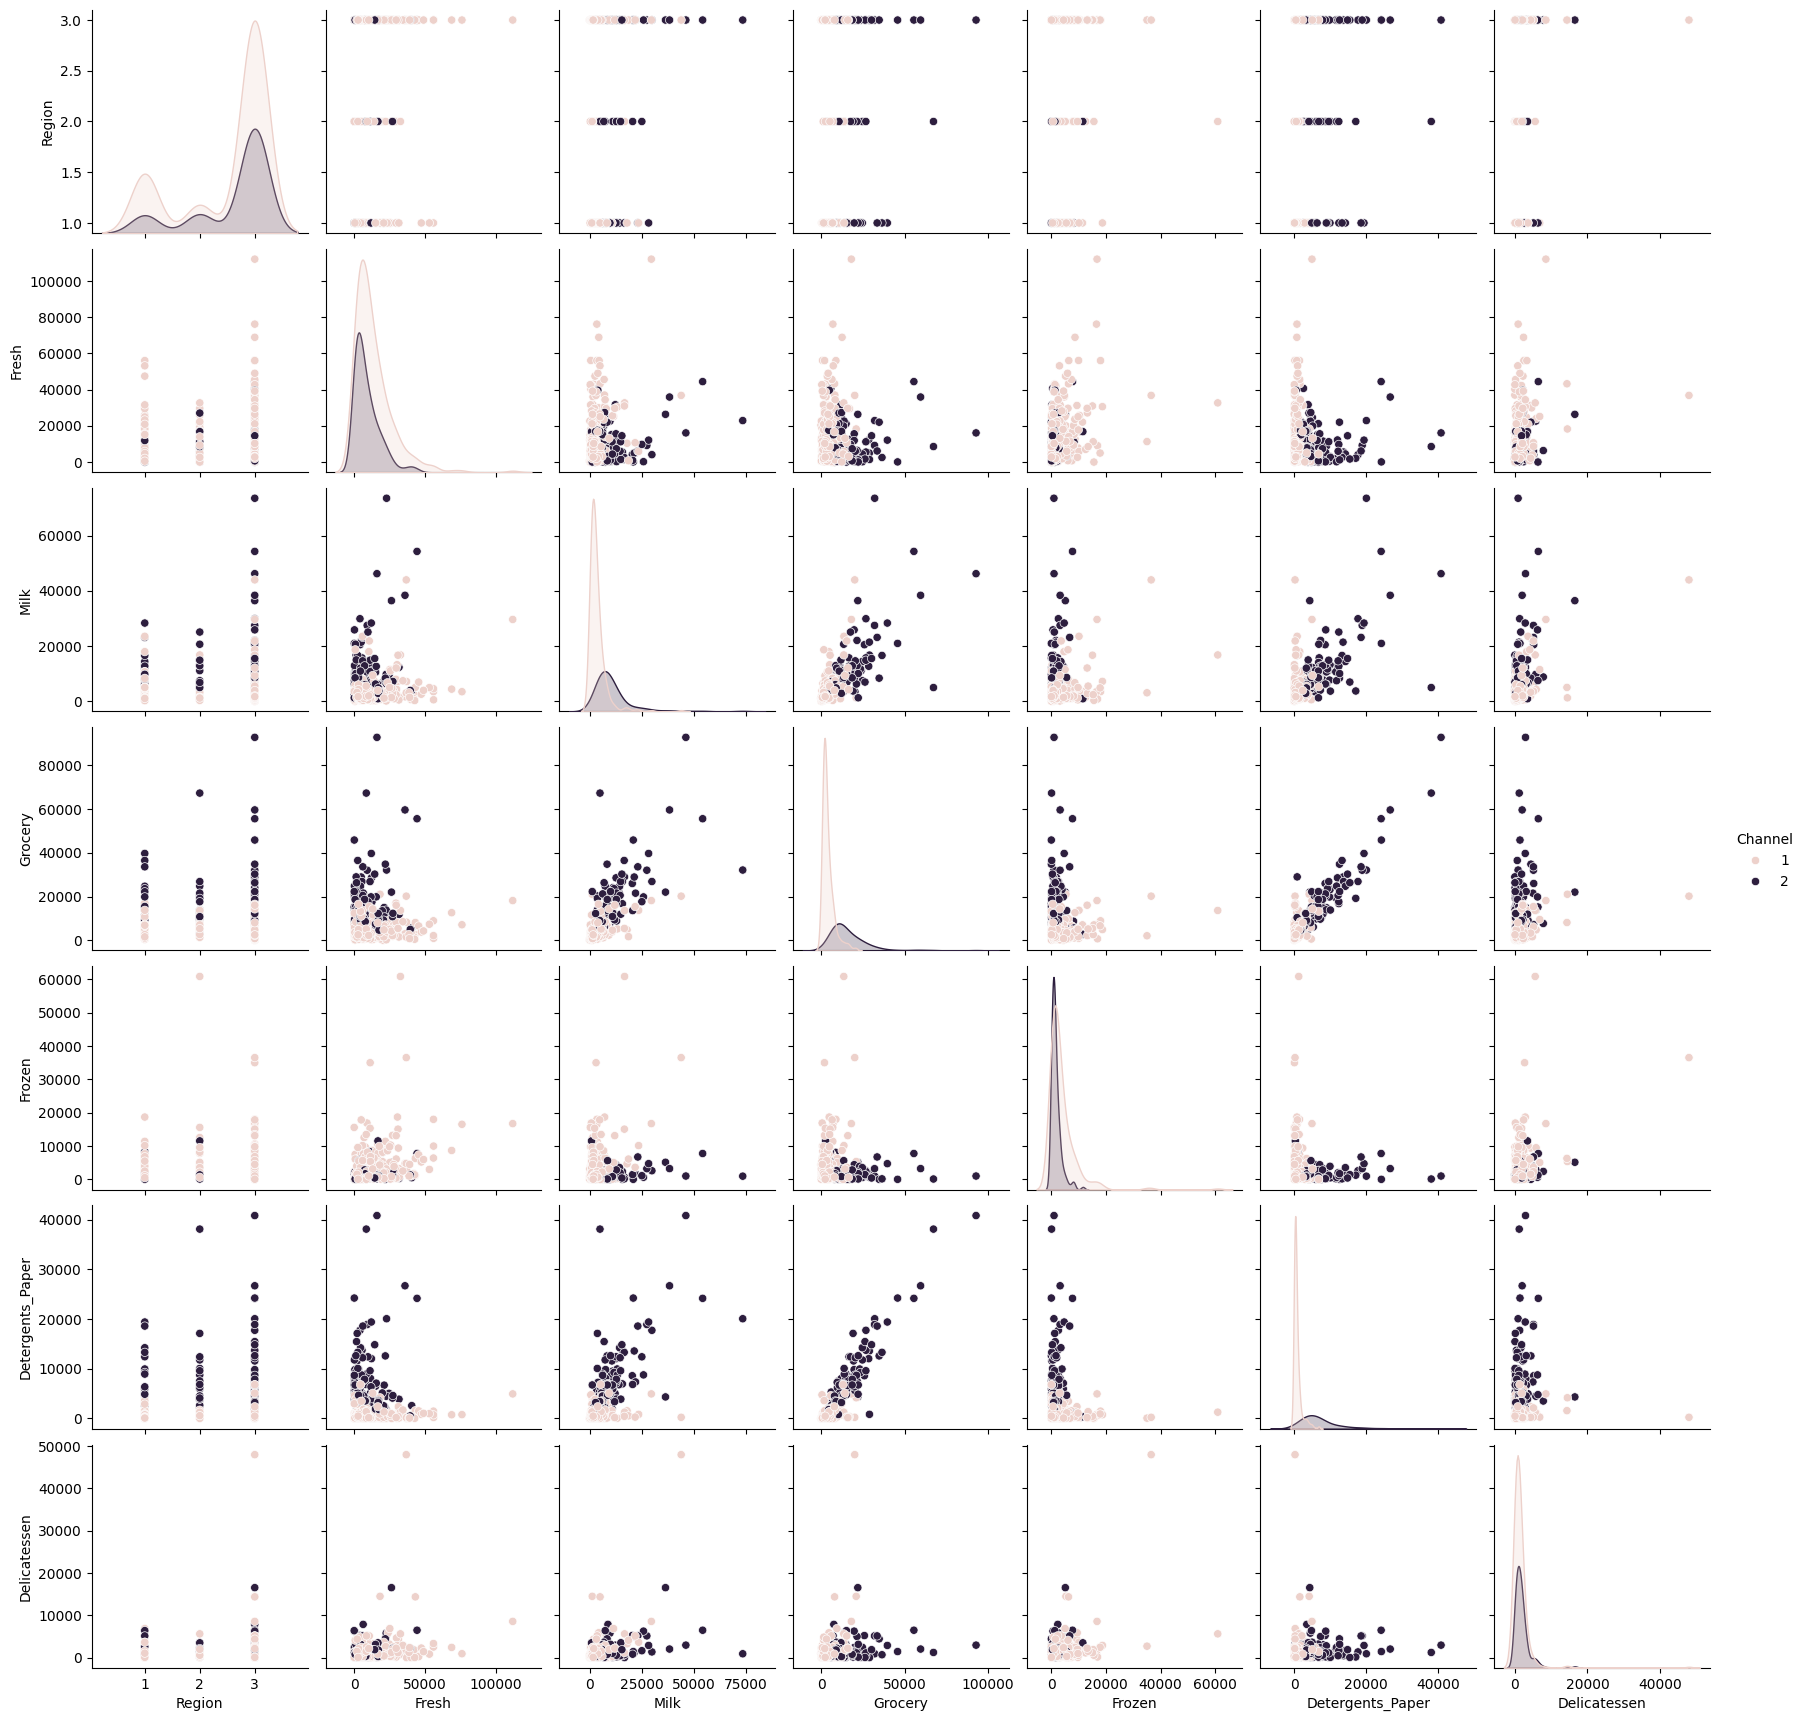

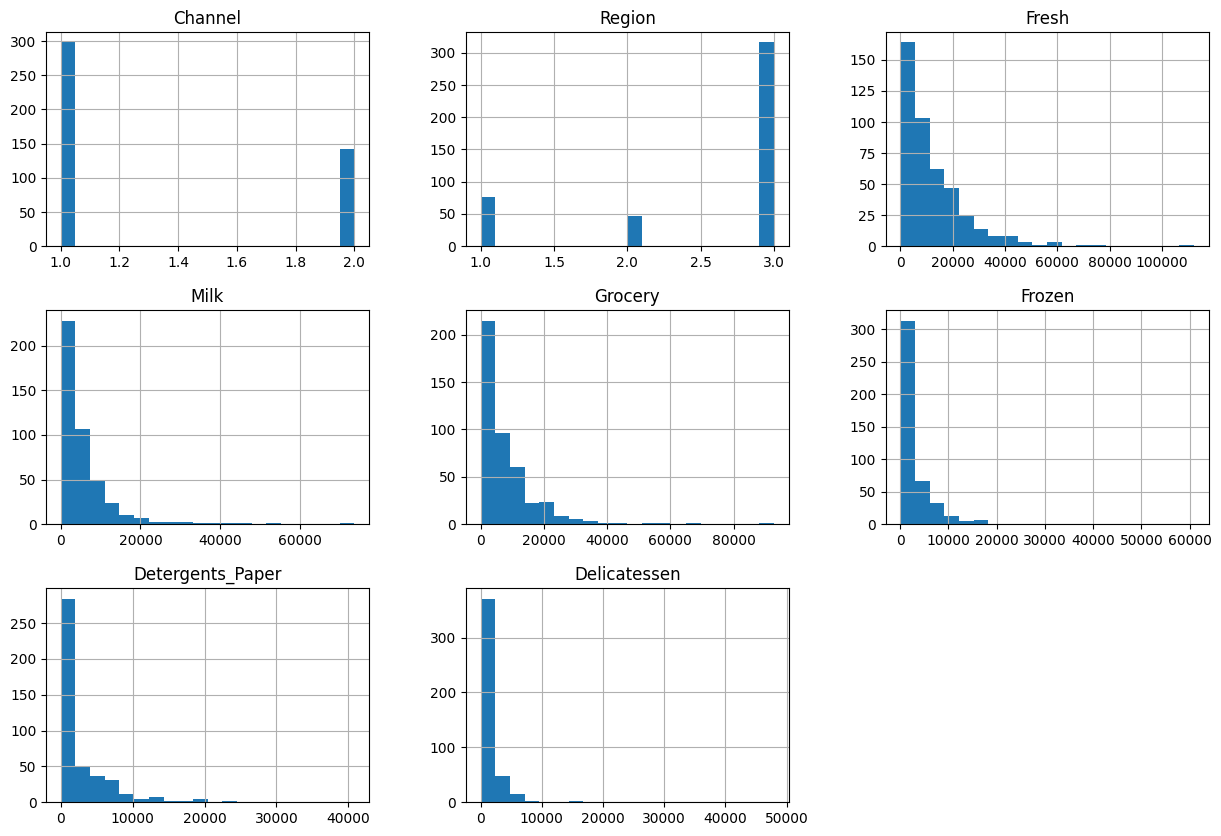

In [56]:
import seaborn as sns

# sns.pairplot(wholesale, hue='Region')
sns.pairplot(wholesale, hue='Channel')
wholesale.hist(bins=20, figsize=(15,10))

In [57]:
# One-hot the nominal columns and then normalize

data = pd.get_dummies(wholesale, columns=['Channel'], prefix='Channel')
data = pd.get_dummies(data, columns=['Region'], prefix='Region')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_s = scaler.fit_transform(data)
data_s = pd.DataFrame(data_s, columns = data.columns)
data_s.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,-1.448652,1.448652,-0.460566,-0.345822,0.626422
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,-1.448652,1.448652,-0.460566,-0.345822,0.626422
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,-1.448652,1.448652,-0.460566,-0.345822,0.626422
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,0.690297,-0.690297,-0.460566,-0.345822,0.626422
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,-1.448652,1.448652,-0.460566,-0.345822,0.626422


In [58]:
from sklearn.decomposition import PCA
pca_any = PCA()
data_pca = pd.DataFrame(pca_any.fit_transform(data_s))
# print(pca_any.explained_variance_ratio_)
# Show sum explained variance with n components
for c in range(1, len(pca_any.explained_variance_ratio_)): 
    s = pca_any.explained_variance_ratio_[0:c].sum()
    print(f"Sum explained variance with {c} components:", s)
# 97% variance explained with 7 components
# data_pca.head()

Sum explained variance with 1 components: 0.34291395481211645
Sum explained variance with 2 components: 0.5163177782496773
Sum explained variance with 3 components: 0.6805073045982777
Sum explained variance with 4 components: 0.786939469693782
Sum explained variance with 5 components: 0.8543349405012303
Sum explained variance with 6 components: 0.9196475875824324
Sum explained variance with 7 components: 0.9687872310030528
Sum explained variance with 8 components: 0.9942908015574241
Sum explained variance with 9 components: 1.0
Sum explained variance with 10 components: 1.0


In [61]:
pca_7 = PCA(n_components=7)
data_pca7 = pd.DataFrame(pca_7.fit_transform(data_s))
print(pca_7.explained_variance_ratio_)


[0.34291395 0.17340382 0.16418953 0.10643217 0.06739547 0.06531265
 0.04913964]


In [81]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Use unsupervised evaluation methods to tune the model (i.e. n_clusters)
    # Trying silhouette, calinski-harabasz, davies-bouldin, and kmeans.inertia_

scores = pd.DataFrame(columns=['clusters', 'inertia', 'silhouette', 'chs', 'dbs'])
for c in range(2, 16): # Reasonable range of n_clusters to try?
    km = KMeans(n_clusters = c, n_init = 10).fit(data_pca7)
    silhouette = metrics.silhouette_score(data_pca7, km.labels_) # higher is better, max = 1
    chs = metrics.calinski_harabasz_score(data_pca7, km.labels_) # higher is better
    dbs = metrics.davies_bouldin_score(data_pca7, km.labels_) # closer to zero (lower) is better
    # scores = scores.append({'clusters': c, 'inertia': km.inertia_, 'silhouette': silhouette, 'chs': chs, 'dbs': dbs})
    scores.loc[len(scores.index)] = [c, km.inertia_, silhouette, chs, dbs]

print("Ideal n_clusters (inertia) (LB):", scores.at[scores['inertia'].idxmin(), 'clusters'])
print("Ideal n_clusters (silhouette) (HB):", scores.at[scores['silhouette'].idxmax(), 'clusters'])
print("Ideal n_clusters (chs) (HB):", scores.at[scores['chs'].idxmax(), 'clusters'])
print("Ideal n_clusters (dbs) (LB):", scores.at[scores['dbs'].idxmin(), 'clusters'])

scores


Ideal n_clusters (inertia) (LB): 15.0
Ideal n_clusters (silhouette) (HB): 9.0
Ideal n_clusters (chs) (HB): 14.0
Ideal n_clusters (dbs) (LB): 14.0


,clusters,inertia,silhouette,chs,dbs
0,2.0,3335.504604,0.392152,177.724357,1.242181
1,3.0,2806.363423,0.396094,146.574331,1.051060
2,4.0,2360.950551,0.422300,143.303739,1.070941
3,5.0,1898.738011,0.488512,159.807935,0.980788
4,6.0,1594.342039,0.495563,168.477181,0.831553
5,7.0,1378.175107,0.470261,173.364152,0.849427
6,8.0,1222.995681,0.497277,174.896507,0.929156
7,9.0,1078.288816,0.523521,180.400002,0.789306
8,10.0,939.918608,0.506393,190.569099,0.743698
9,11.0,855.558365,0.488070,192.215585,0.761937
